In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import sympy as sym
import seaborn as sn
import pycollocation
from __future__ import division

import inputs
import models
import solvers
import shooting
import pyam

In [3]:
pycollocation.__version__

'0.4.0-alpha'

## Inputs and Production Function

In [43]:
# define some workers skill
x, loc1, mu1, sigma1 = sym.var('x, loc1, mu1, sigma1')
skill_cdf = 142.85 * (0.5 + 0.5 * sym.erf((sym.log(x - loc1) - mu1) / sym.sqrt(2 * sigma1**2)))
skill_params = {'loc1': -1e-1, 'mu1': 0.0, 'sigma1': 1.0}
skill_bounds = [-skill_params['loc1'], 1e2]

workers = pyam.Input(var=x,
                     cdf=skill_cdf,
                     params=skill_params,
                     bounds=skill_bounds,
                     )

# define some firms
y, loc2, mu2, sigma2 = sym.var('y, loc2, mu2, sigma2')
productivity_cdf = 0.5 + 0.5 * sym.erf((sym.log(y - loc2) - mu2) / sym.sqrt(2 * sigma2**2))
productivity_params = {'loc2': -1e-1, 'mu2': 0.0, 'sigma2': 1.0}
productivity_bounds = [-productivity_params['loc2'], 1e2]

firms = pyam.Input(var=y,
                   cdf=productivity_cdf,
                   params=productivity_params,
                   bounds=productivity_bounds,
                   )


In [44]:
# define symbolic expression for CES between x and y
omega_A, sigma_A, Big_A = sym.var('omega_A, sigma_A, Big_A')
A = ((omega_A * x**((sigma_A - 1) / sigma_A) + 
     (1 - omega_A) * y**((sigma_A - 1) / sigma_A))**(sigma_A / (sigma_A - 1))) 

# define symbolic expression for CES between x and y
r, l, omega_B, sigma_B = sym.var('r, l, omega_B, sigma_B')
B = r**(omega_B) * l**(1 - omega_B)

F = 100000.0 * A * B * Big_A

# positive assortativity requires that sigma_A * sigma_B < 1
F_params = {'omega_A':0.25, 'omega_B':0.5, 'sigma_A':0.5, 'Big_A':1.2}

## Set up a boundary value problem and chose the collocation solver

In [45]:
problem = pyam.AssortativeMatchingProblem(assortativity='positive',
                                          input1=workers,
                                          input2=firms,
                                          F=F,
                                          F_params=F_params)

In [46]:
solver = pycollocation.OrthogonalPolynomialSolver(problem)

## Compute some decent initial guess

In [47]:
initial_guess = pyam.OrthogonalPolynomialInitialGuess(solver)
initial_polys = initial_guess.compute_initial_guess("Chebyshev",
                                                    degrees={'mu': 175, 'theta': 175},
                                                    exp=0.5)

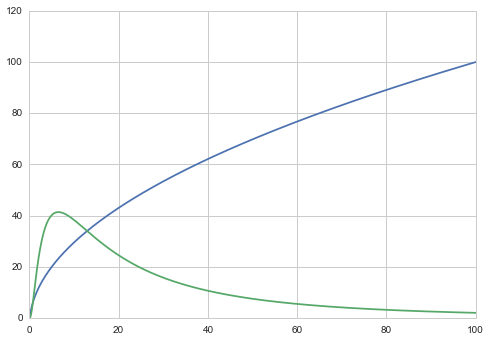

In [48]:
# quickly plot the initial conditions
sn.set_style("whitegrid")
xs = np.linspace(workers.lower, workers.upper, 1000)
plt.plot(xs, initial_polys['mu'](xs))
plt.plot(xs, initial_polys['theta'](xs))
plt.grid('on')

In [49]:
domain = [workers.lower, workers.upper]
initial_coefs = {'mu': initial_polys['mu'].coef,
                 'theta': initial_polys['theta'].coef}

solver.solve(kind="Chebyshev",
             coefs_dict=initial_coefs,
             domain=domain,
             method='hybr')

In [50]:
solver.result.success

True

## Plot time!

In [51]:
viz = pycollocation.Visualizer(solver)

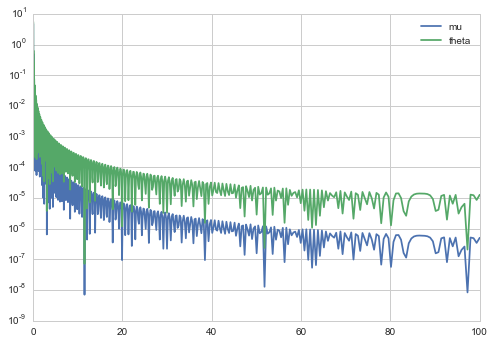

In [52]:
viz.interpolation_knots = np.logspace(-1, 2, 1000)
viz.normalized_residuals.plot(logy=True)
plt.show()

Nice errors!

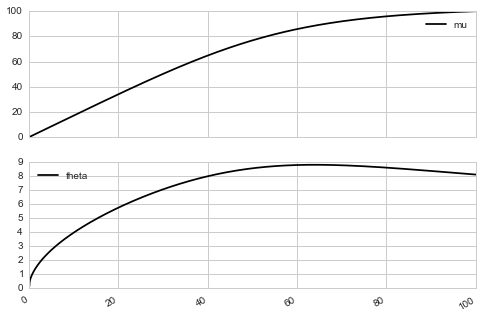

In [53]:
viz.solution.plot(subplots=True)
plt.show()

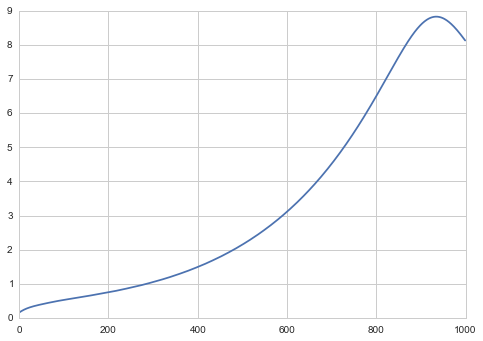

In [54]:
plt.plot(viz.solution.theta)
plt.show()

As you can see, the theta function is hump-shaped. Nothing special, but when calculating the pdf some arrangements have to be done for this: sort the thetas preserving the order (so we can relate them to their xs) and then use carefully the right x for calculating the pdf.

The principle of Philipp's trick is:

$Cdf_x(x_i)$ can be interpreted as *number of workers with ability x*. $\theta_i$ is the size of the firms that employs workers of kind $x_i$. As all firms that match with workers type $x_i$ choose the same firm size, $Cdf_x(x_i)/\theta_i$ is the number of firms of size $\theta_i$.

Say there are 100 workers with ability $x_i$, and their associated firm size $\theta_i$ is 2. Then there are $100/2 = 50$ $ \theta_i$ firms

In [55]:
import operator
# Sorting the thetas preserving the order
n_thetas = dict(zip(list(map(str, range(0,len(viz.solution.theta)))),viz.solution.theta))
sort_thetas = sorted(n_thetas.items(), key=operator.itemgetter(1))  # list of tuples (original position, theta)
theta_range = sorted(viz.solution.theta)                            # Sorted theta range

# Using the pdf of workers
pdf_x = workers.evaluate_pdf(viz.solution.index.values)         # calculates pdf of xs in one step
n_pdf_x = dict(enumerate(pdf_x))                            # creates a dictionary where the keys are the #obs of x
pdf_theta_hat = np.empty(0)

for pair in sort_thetas:
    index = int(pair[0])
    pdf_theta_hat  = np.hstack((pdf_theta_hat ,(n_pdf_x[index]/pair[1]))) # Adds pdf_x(x(theta))/theta

cdf_theta_hat  = np.cumsum(pdf_theta_hat)                   # Backing up model cdf
cdf_theta_hat  = cdf_theta_hat /cdf_theta_hat [-1]          # Normalization of the model cdf

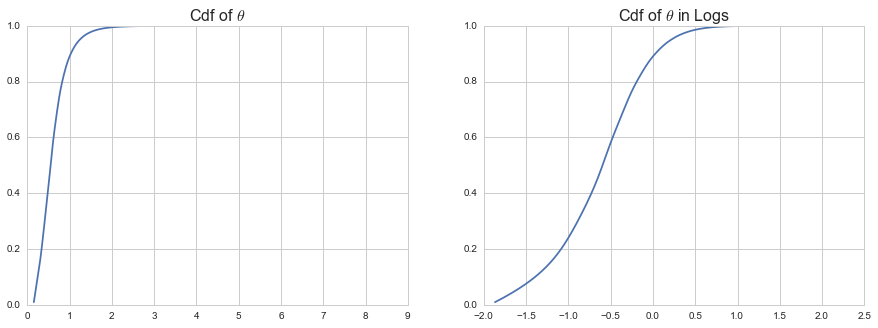

In [56]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(theta_range, cdf_theta_hat)
plt.title("Cdf of $\\theta$", fontsize=16)
plt.subplot(1,2,2)
plt.plot(np.log(theta_range), cdf_theta_hat)
plt.title("Cdf of $\\theta$ in Logs", fontsize=16)
plt.show()

Note: the long (almost invisible) tail of the Cdfs is due to the extreme value of 100 at the end.